In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from shallow_fbcsp import ShallowFBCSPNet
import pandas as pd
from collections import OrderedDict
import math

In [2]:
def linear_kernel(X):
    """Computes the linear kernel matrix for X."""
    return torch.matmul(X,X.T)  # Dot product

def centering_matrix(K):
    """Apply centering to the kernel matrix."""
    n = K.shape[0]
    H = torch.eye(n) - (1.0 / n) * torch.ones((n, n), device=K.device)
    return H @ K @ H  # Centered kernel matrix

def compute_hsic(K_x, K_y):
    """
    Computes the Hilbert-Schmidt Independence Criterion (HSIC).
    
    Parameters:
    - X: (n_samples, n_features_X) numpy array
    - Y: (n_samples, n_features_Y) numpy array
    - kernel_X: function to compute the kernel matrix for X
    - kernel_Y: function to compute the kernel matrix for Y
    
    Returns:
    - HSIC value (float)
    """
    K_x_centered = centering_matrix(K_x)
    K_y_centered = centering_matrix(K_y)
    hsic_value = np.trace(K_x_centered @ K_y_centered) / ((K_x.shape[0] - 1) ** 2)
    return hsic_value
  
def compute_CKA(K_x,K_y):
  """
  compute CKA between two X,Y activations
  
  Parameters:
  - X: (n_samples, x_features)
  - Y: (n_samples, y_features)
  - kernel_X: kernel for X
  - kernel_Y: kernel for Y  
  """
  HSIC_KL = compute_hsic(K_x,K_y) 
  HSIC_KK = compute_hsic(K_x,K_x)
  HSIC_LL = compute_hsic(K_y,K_y)
  numerator = HSIC_KL
  denominator = math.sqrt(HSIC_KK * HSIC_LL)
  return(numerator/denominator).item()


In [3]:
# Define model parameters
in_chans = 22
n_classes = 4
n_channels = 22
input_window_samples = 1125
# Load two models for comparison
model= torch.load("braindecode_model_temponly_1.pth",weights_only = False,map_location=torch.device('cpu'))
model2 =ShallowFBCSPNet(in_chans, n_classes, input_window_samples)



In [4]:
print(model2)

Layer (type (var_name):depth-idx)        Input Shape               Output Shape              Param #                   Kernel Shape
ShallowFBCSPNet (ShallowFBCSPNet)        [1, 22, 1125]             [1, 4]                    --                        --
├─SafeLog (pool_nonlin_exp): 1-1         [1, 22, 1125]             [1, 22, 1125]             --                        --
├─Ensure4d (ensuredims): 1-2             [1, 22, 1125]             [1, 22, 1125, 1]          --                        --
├─Rearrange (dimshuffle): 1-3            [1, 22, 1125, 1]          [1, 1, 1125, 22]          --                        --
├─Conv2d (conv_time): 1-4                [1, 1, 1125, 22]          [1, 40, 1101, 22]         1,040                     [25, 1]
├─Conv2d (conv_spat): 1-5                [1, 40, 1101, 22]         [1, 40, 1101, 1]          35,200                    [1, 22]
├─BatchNorm2d (bnorm): 1-6               [1, 40, 1101, 1]          [1, 40, 1101, 1]          80                        --
├─Ex

In [5]:
print(model)

Layer (type (var_name):depth-idx)        Input Shape               Output Shape              Param #                   Kernel Shape
ShallowFBCSPNet (ShallowFBCSPNet)        [1, 22, 1125]             [1, 4]                    --                        --
├─SafeLog (pool_nonlin_exp): 1-1         [1, 22, 1125]             [1, 22, 1125]             --                        --
├─Ensure4d (ensuredims): 1-2             [1, 22, 1125]             [1, 22, 1125, 1]          --                        --
├─Rearrange (dimshuffle): 1-3            [1, 22, 1125, 1]          [1, 1, 1125, 22]          --                        --
├─Conv2d (conv_time): 1-4                [1, 1, 1125, 22]          [1, 40, 1101, 22]         1,040                     [25, 1]
├─Conv2d (conv_spat): 1-5                [1, 40, 1101, 22]         [1, 40, 1101, 1]          35,200                    [1, 22]
├─BatchNorm2d (bnorm): 1-6               [1, 40, 1101, 1]          [1, 40, 1101, 1]          80                        --
├─Ex

In [6]:
import os
import torch

def extract_model_activations(model, input_tensor, output_dir, batch_size=128):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    activations = OrderedDict()

    def get_activation(name):
        def hook(model, input, output):
            activations[name] = output.detach()
        return hook

    # Register hooks for specific layers
    for name, layer in model.named_modules():
        if name == "conv_time" or name == "conv_spat" or name =="pool":  # Modify as per your layer names
            layer.register_forward_hook(get_activation(name))

    model.eval()

    with torch.no_grad():
        for i in range(0, input_tensor.shape[0], batch_size):
            batch = input_tensor[i:i + batch_size]  # Select current batch
            _ = model(batch)  # Forward pass through the model

            # Save activations after each batch
            for name, activation in activations.items():
                batch_idx = i // batch_size + 1  # This determines the batch number
                print(f"saving: {name}_batch_{batch_idx}.pt")
                torch.save(activation, os.path.join(output_dir, f"{name}_batch_{batch_idx}.pt"))
            
            # Clear activations list after saving
            activations.clear()
            torch.cuda.empty_cache()  # Optional: Clear GPU memory after each batch



In [7]:
import pickle
with open('Datasets/test_set.pkl', 'rb') as f:
    test_set = pickle.load(f)

In [8]:
X = torch.stack([torch.from_numpy(test_set[i][0]) for i in range(len(test_set))])

total_samples = X.shape[0]
print(X.shape)  # Verify the tensor shape
print(type(X))  # Should output <class 'torch.Tensor'>


torch.Size([2592, 22, 1125])
<class 'torch.Tensor'>


In [9]:
print(model.conv_time.weight.device)  # Check the device of the conv_time layer
print(next(model.parameters()).device)


cpu
cpu


In [10]:

batch_size = 128
total_samples = X.shape[0]
print(total_samples)

2592


In [11]:
extract_model_activations(model,X,output_dir="Datasets/activations/model1/",batch_size=batch_size)


saving: conv_time_batch_1.pt
saving: conv_spat_batch_1.pt
saving: pool_batch_1.pt
saving: conv_time_batch_2.pt
saving: conv_spat_batch_2.pt
saving: pool_batch_2.pt
saving: conv_time_batch_3.pt
saving: conv_spat_batch_3.pt
saving: pool_batch_3.pt
saving: conv_time_batch_4.pt
saving: conv_spat_batch_4.pt
saving: pool_batch_4.pt
saving: conv_time_batch_5.pt
saving: conv_spat_batch_5.pt
saving: pool_batch_5.pt
saving: conv_time_batch_6.pt
saving: conv_spat_batch_6.pt
saving: pool_batch_6.pt
saving: conv_time_batch_7.pt
saving: conv_spat_batch_7.pt
saving: pool_batch_7.pt
saving: conv_time_batch_8.pt
saving: conv_spat_batch_8.pt
saving: pool_batch_8.pt
saving: conv_time_batch_9.pt
saving: conv_spat_batch_9.pt
saving: pool_batch_9.pt
saving: conv_time_batch_10.pt
saving: conv_spat_batch_10.pt
saving: pool_batch_10.pt
saving: conv_time_batch_11.pt
saving: conv_spat_batch_11.pt
saving: pool_batch_11.pt
saving: conv_time_batch_12.pt
saving: conv_spat_batch_12.pt
saving: pool_batch_12.pt
saving:

In [12]:
extract_model_activations(model2,X,output_dir="Datasets/activations/model2/",batch_size=batch_size)

saving: conv_time_batch_1.pt
saving: conv_spat_batch_1.pt
saving: pool_batch_1.pt
saving: conv_time_batch_2.pt
saving: conv_spat_batch_2.pt
saving: pool_batch_2.pt
saving: conv_time_batch_3.pt
saving: conv_spat_batch_3.pt
saving: pool_batch_3.pt
saving: conv_time_batch_4.pt
saving: conv_spat_batch_4.pt
saving: pool_batch_4.pt
saving: conv_time_batch_5.pt
saving: conv_spat_batch_5.pt
saving: pool_batch_5.pt
saving: conv_time_batch_6.pt
saving: conv_spat_batch_6.pt
saving: pool_batch_6.pt
saving: conv_time_batch_7.pt
saving: conv_spat_batch_7.pt
saving: pool_batch_7.pt
saving: conv_time_batch_8.pt
saving: conv_spat_batch_8.pt
saving: pool_batch_8.pt
saving: conv_time_batch_9.pt
saving: conv_spat_batch_9.pt
saving: pool_batch_9.pt
saving: conv_time_batch_10.pt
saving: conv_spat_batch_10.pt
saving: pool_batch_10.pt
saving: conv_time_batch_11.pt
saving: conv_spat_batch_11.pt
saving: pool_batch_11.pt
saving: conv_time_batch_12.pt
saving: conv_spat_batch_12.pt
saving: pool_batch_12.pt
saving:

In [13]:
length = torch.load(f"Datasets/activations/model1/conv_time_batch_{3}.pt")
print(length.shape)

torch.Size([128, 40, 1101, 22])


In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import OrderedDict
del X
# Use OrderedDict to preserve the order of layer names
layer_names_model1 = ['conv_time', 'conv_spat','pool']
layer_names_model2 = layer_names_model1


print(layer_names_model1)
print(layer_names_model2)

['conv_time', 'conv_spat', 'pool']
['conv_time', 'conv_spat', 'pool']


In [15]:
import math
batch_nr = total_samples /batch_size

batch_nr

20.25

In [16]:




def compute_kernel_full_highmem(layer, batch_nr, model_number):
    """Computes the linear kernel for all samples at once."""
    

    activations_list = []
    
    for batch_idx in range(1, math.ceil(batch_nr+1)):
        print(f"\rLoading batch {batch_idx} for {layer} in model {model_number}", end='', flush=True)
        

        batch_activations = torch.load(f"Datasets/activations/model{model_number}/{layer}_batch_{batch_idx}.pt")
        batch_activations = batch_activations.reshape(batch_activations.shape[0], -1)  # Flatten
        
        activations_list.append(batch_activations)
    
    all_activations = torch.cat(activations_list, dim=0)
    print("\nFinal Activations Shape:", all_activations.shape)

    full_kernel = torch.matmul(all_activations, all_activations.T)

    return full_kernel

# model_1_kernels = OrderedDict()
# model_2_kernels = OrderedDict()

# for layer in layer_names_model1:
#     model_1_kernels[layer] = compute_kernel_full_highmem(layer, batch_nr,1)
# for layer in layer_names_model2:
#     model_2_kernels[layer] = compute_kernel_full_highmem(layer,batch_nr,2)







In [17]:
def compute_kernel_full_lowmem(layer, batch_nr, model_number, total_samples, batch_size, n_batches=1, use_cuda=False):
    """Computes the full kernel matrix in batches efficiently using matrix multiplication."""
    
    device = torch.device("cuda" if use_cuda and torch.cuda.is_available() else "cpu")

    full_kernel = torch.zeros((total_samples, total_samples), dtype=torch.float32, device=device)
    
    for batch_idx in range(1, math.ceil(math.ceil(batch_nr) / n_batches) + 1):
        print(f"\rLoading batches {batch_idx * n_batches - (n_batches - 1)}-{batch_idx * n_batches} for {layer} in model {model_number}", 
              end='', flush=True)

        batch_activations_list = []
        start_idx_col = (batch_idx - 1) * batch_size * n_batches
        end_idx_col = min(start_idx_col + batch_size * n_batches, total_samples)  

        # Load multiple batches at once
        for sub_batch in range(n_batches):
            batch_file_idx = (batch_idx - 1) * n_batches + sub_batch + 1
            if batch_file_idx > math.ceil(batch_nr):
                break
            batch_activations = torch.load(
                f"Datasets/activations/model{model_number}/{layer}_batch_{batch_file_idx}.pt"
            ).to(device)
            batch_activations_list.append(batch_activations.reshape(batch_activations.shape[0], -1))

        if not batch_activations_list:
            continue

        batch_activations = torch.cat(batch_activations_list, dim=0)  # Merge batches

        for batch_idx2 in range(1, math.ceil(math.ceil(batch_nr) / n_batches) + 2):
            batch_activations_transpose_list = []
            start_idx_row = (batch_idx2 - 1) * batch_size * n_batches
            end_idx_row = min(start_idx_row + batch_size * n_batches, total_samples)

            # Load multiple batches at once
            for sub_batch2 in range(n_batches):
                batch_file_idx2 = (batch_idx2 - 1) * n_batches + sub_batch2 + 1
                if batch_file_idx2 > math.ceil(batch_nr):
                    break
                batch_activations_transpose = torch.load(
                    f"Datasets/activations/model{model_number}/{layer}_batch_{batch_file_idx2}.pt"
                ).to(device)
                batch_activations_transpose_list.append(batch_activations_transpose.reshape(batch_activations_transpose.shape[0], -1))

            if not batch_activations_transpose_list:
                continue

            batch_activations_transpose = torch.cat(batch_activations_transpose_list, dim=0)

            kernel_block = batch_activations @ batch_activations_transpose.T
            full_kernel[start_idx_col:end_idx_col, start_idx_row:end_idx_row] = kernel_block
            full_kernel[start_idx_row:end_idx_row, start_idx_col:end_idx_col] = kernel_block.T  # Use symmetry

    return full_kernel.cpu()


def compute_full_kernels(layer_names_model1, layer_names_model2, batch_nr, total_samples,batch_size,n_batches):
    """Computes the kernels for both models."""
    model_1_kernels = {}
    model_2_kernels = {}

    # Compute kernels for model 1
    for layer in layer_names_model1:
        model_1_kernels[layer] = compute_kernel_full_lowmem(layer, batch_nr, 1, total_samples,batch_size,n_batches)

    # Compute kernels for model 2
    for layer in layer_names_model2:
        model_2_kernels[layer] = compute_kernel_full_lowmem(layer, batch_nr, 2, total_samples,batch_size,n_batches)

    return model_1_kernels, model_2_kernels

model_1_kernels = OrderedDict()
model_2_kernels = OrderedDict()
layer_names_model = layer_names_model1 

    
model_1_kernels, model_2_kernels = compute_full_kernels(layer_names_model, layer_names_model, batch_nr,total_samples,batch_size,2)

Loading batches 1-2 for conv_time in model 1

Loading batches 21-22 for pool in model 2del 2

In [18]:

print(model_1_kernels["conv_time"].shape)
if (model_1_kernels["conv_time"] == 0).any():
    print("The tensor contains at least one zero value.")
else:
    print("No zero values in the tensor.")

print(model_1_kernels["pool"])


torch.Size([2592, 2592])
No zero values in the tensor.
tensor([[4354.4941, 3581.6069, 3531.5522,  ..., 3072.9255, 4246.0312,
         3990.4431],
        [3581.6069, 3504.5457, 3185.0710,  ..., 2780.1140, 3826.2139,
         3562.2351],
        [3531.5522, 3185.0710, 3473.2515,  ..., 2775.7959, 3734.8384,
         3547.5334],
        ...,
        [3072.9255, 2780.1140, 2775.7959,  ..., 2775.1204, 3375.6501,
         3103.9297],
        [4246.0312, 3826.2139, 3734.8384,  ..., 3375.6501, 5377.9814,
         4307.5093],
        [3990.4431, 3562.2351, 3547.5334,  ..., 3103.9297, 4307.5093,
         4612.5444]])


In [19]:
cka_results = OrderedDict()

for layer1, K_x in model_1_kernels.items():
    for layer2, K_y in model_2_kernels.items():
        cka_value = compute_CKA(K_x, K_y)
        cka_results[(layer1, layer2)] = cka_value
        print(f"CKA({layer1}, {layer2}): {cka_value}")

CKA(conv_time, conv_time): 0.9934050820742923
CKA(conv_time, conv_spat): 0.9788495684684053
CKA(conv_time, pool): 0.31432706053251025
CKA(conv_spat, conv_time): 0.87032200763708
CKA(conv_spat, conv_spat): 0.8586771375234233
CKA(conv_spat, pool): 0.3162279829252574
CKA(pool, conv_time): 0.07823009547922961
CKA(pool, conv_spat): 0.07591207960512499
CKA(pool, pool): 0.18666662314812527


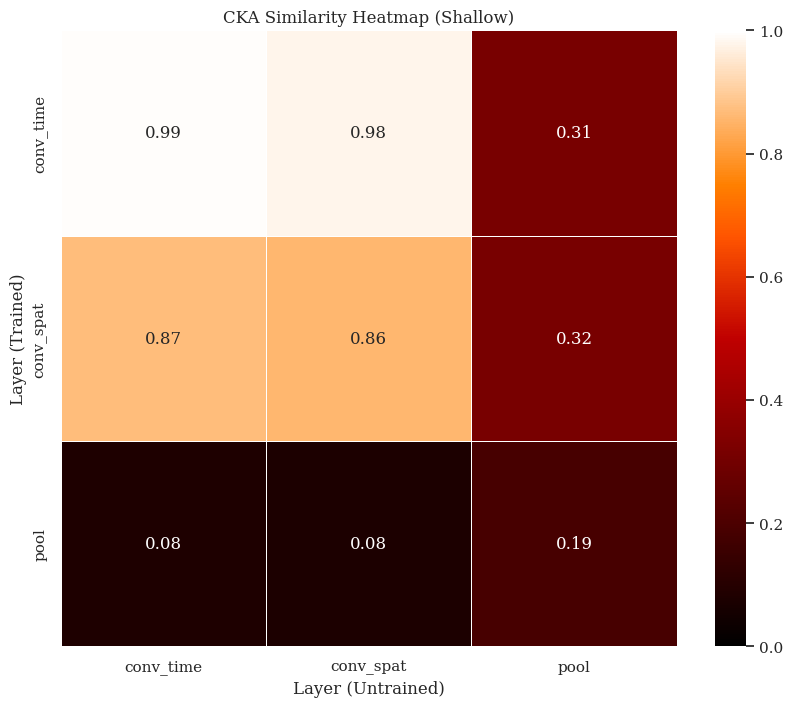

In [22]:
# Initialize a matrix for the CKA similarities
n_layers1 = len(layer_names_model1)
n_layers2 = len(layer_names_model2)
matrix = np.zeros((n_layers1, n_layers2))

# Fill the matrix with the CKA similarity values
for (layer1, layer2), similarity in cka_results.items():
    # Get the index for layer1 in model1 and layer2 in model2
    if layer1 in layer_names_model1:
        i = layer_names_model1.index(layer1)  # Index for model 1 layer
    else:
        i = -1  # Invalid index (in case of layer not in model1)

    if layer2 in layer_names_model2:
        j = layer_names_model2.index(layer2)  # Index for model 2 layer
    else:
        j = -1  # Invalid index (in case of layer not in model2)
    
    if i != -1 and j != -1:  # Only fill the matrix if both indices are valid
        matrix[i, j] = similarity

# Create a DataFrame for better visualization
df = pd.DataFrame(matrix, index=layer_names_model1, columns=layer_names_model2)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df, annot=True, cmap='gist_heat', fmt='.2f', square=True, linewidths=0.5, cbar=True, vmin=0, vmax=1)
plt.title('CKA Similarity Heatmap (Shallow)')
plt.xlabel(f'Layer (Untrained)')
plt.ylabel(f'Layer (Trained)')
plt.show()
